In [44]:
import pennylane as qml
from pennylane import numpy as np
from IPython.display import display, Latex

# from numba import jit

# numpy 
import numpy as np_
import scipy as sp

import matplotlib.pyplot as plt

# 2-qubit
dev = qml.device('default.mixed', wires = 2)

# == Hamiltonian setup == 
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)

In [45]:
# == Global paras ==
Paras_global, Phi_global, Gamma_ps  = np_.zeros(6), 0, 0

# Return one by one
def Dephase_factor(tau):
    Calculate_Dephase = 1 - np.exp(-2 * tau)
    
    return Calculate_Dephase

$$
\rho_{After-Hadamard} = 

\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

where,
\quad \gamma = 
1 - e^{-2 \tau}
$$


$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [46]:
# == Generate circuit ==

# circuit_1
@qml.qnode(dev)
def circuit_1(paras):
    # Call global phi
    global Phi_global
    phi = Phi_global
    
    # Assign paras
    theta_init, tau_1, tau_2 = paras[0], paras[1], paras[2]
    
    # Calculate dephase factor with given paras
    gamma_dephase_in = np_.zeros(3)
    for i in range(3):
        gamma_dephase_in[i] = Dephase_factor(paras[i+3])
        
        
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, tau_1, 1)
    qml.PhaseDamping(gamma_dephase_in[0], wires = 0)
    qml.PhaseDamping(gamma_dephase_in[0], wires = 1)
    
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, tau_2, 1)
    qml.PhaseDamping(gamma_dephase_in[1], wires = 0)
    qml.PhaseDamping(gamma_dephase_in[1], wires = 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulater
    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in[2], wires = 0)
    qml.PhaseDamping(gamma_dephase_in[2], wires = 1)
    
    qml.RY(-np.pi/2, wires=0)
    qml.RY(-np.pi/2, wires=1)
    
    return qml.density_matrix(wires=[0, 1])


# Circuit_2: Calculate decoherence by using [tau -> gamma_dephase_in] conversion
@qml.qnode(dev)
def Post_selection_Dephase(phi):
    
    # theta_init, tau_1, tau_2, gamma_1, gamma_2, gamma_3 = paras[0], paras[1], paras[2], paras[3], paras[4], paras[5]
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit_1(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires=[0, 1])
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    K_H = K.conj().T
    
    Numerator = sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H)
    Denominator = np.trace(sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H))
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires=[0, 1])
    
    return qml.density_matrix(wires=[0, 1])  

$$ K =  \begin{bmatrix}
\sqrt{1-\gamma} & 0 \\
0 & 1 
\end{bmatrix}  $$


$$
\rho_{ps} = 
\frac{(K \otimes K) \rho (K^{\dagger} \otimes K ^{\dagger})}

{Tr[(K \otimes K) \rho (K^{\dagger} \otimes K ^{\dagger})]}
$$

![Alt text](image-1.png)

In [47]:
# == Cost function ==
def Cost_function(paras):
    # expect: theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3 = paras[0], paras[1], paras[2], paras[3], paras[4], paras[5]
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [48]:
# == Check for maximum tau <-> gamma ==
tau_test = 18

print('Gamma =', Dephase_factor(tau_test), ', [ at tau =',tau_test,']' )

Gamma = 0.9999999999999998 , [ at tau = 18 ]


In [49]:
# == SLSQP -> Return Data_set:[phi, CFI, 6-Paras] ==
def SLSQP(Sweep_Data, paras, gamma_ps_select):
    # Create Data array
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    
    Data = np_.zeros((len(PHI), len(paras) + 1))
    Data = np_.hstack((PHI, Data))
    
    # Set Data index
    CFI_INDEX, PARAS_INDEX = 1, 2
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps_select
    
    # Optimize begin
    for i in range(len(PHI)):
        # Assign global phi from Generated PHI array
        Phi_global = Data[i][0]
        
        # Assign global paras for each phi
        
        # Set constraints for gamma_from_tau
        tau_upper = 18
        Constraints = [(-float('inf'), float('inf'))] * 3 + [(1e-100, tau_upper)] * 3
        
        Paras_global = paras 
        Result_SLSQP = sp.optimize.minimize(Cost_function, np_.array([1, 1, 1, 0.1, 0.1, 0.1]), method = 'SLSQP', bounds = Constraints)
        Data[i][CFI_INDEX] = -Result_SLSQP.fun
        
        # Store data in array
        for j in range(len(paras)):
            Data[i][PARAS_INDEX + j] = Result_SLSQP.x[j]
                
    return Data

Data = 

array([ [PHI_0, CFI_0, theta_0, tau_1, tau_2, tau_d1, tau_d2, tau_d3], 

...

In [50]:
# == Fixed to gamma_ps = 0.8 ==
# == Sweep for 0 ~ pi*3 == 
Sweep_data = np_.array([1e-3, np.pi * 3 + 1e-3, 1e-1])
Para_init = np_.array([1, 1, 1, 1e-1, 1e-1, 1e-1])
Gamma_ps_preset = 0.8

Optimized_Result = SLSQP(Sweep_data, Para_init, Gamma_ps_preset)

In [51]:
# Optimized_Result[:, 0]

Optimized_Result[:, 1]

array([99.99602265, 96.75609591, 86.47273972, 10.78058296, 99.69129666,
       73.93744692, 83.9333765 , 94.58129294, 76.40619106, 99.97723262,
       98.23664836, 99.87952122, 86.27372049, 99.5648002 , 96.83198312,
       99.86590464, 99.96976751, 50.68870929, 91.17182135,  8.58000566,
       99.55416674, 99.77450608, 98.019887  ,  0.96344859, 97.64808839,
       98.43473615, 88.23947248, 98.95782134, 90.77895845, 98.68841148,
       60.70049157, 99.96058401, 99.89539114, 38.83359448, 98.49942576,
       74.3380569 ,  0.16050473, 99.12549714, 77.59479747,  0.93116982,
       97.68388486,  1.95218937, 24.1478869 , 88.18248067, 98.83731882,
       99.79019188, 95.37043167, 99.95757092, 85.24229897, 99.81180627,
       99.64969658, 98.70315837, 89.77927828, 77.31786468, 99.31858359,
       60.87547443, 97.89277953, 96.13815543, 99.82732059, 99.03043603,
       73.5451436 , 98.3105955 , 98.77483501, 99.95418141, 99.5512845 ,
       22.23666195, 93.92266572, 86.06863372, 98.17542287, 97.98

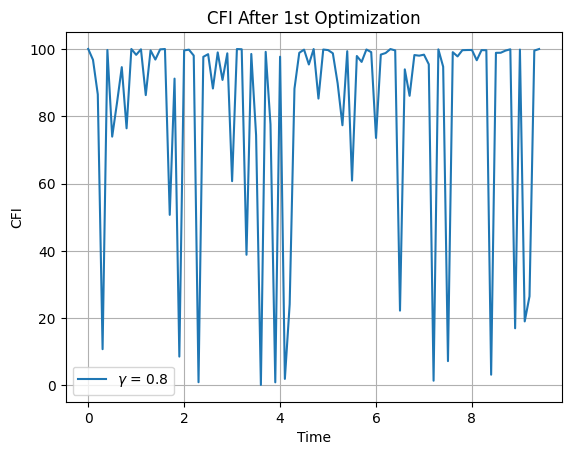

In [52]:
# == Temporary Plot for gamma_ps = 0.8
plt.plot(Optimized_Result[:, 0], Optimized_Result[:, 1], label = f'$\gamma$ = {Gamma_ps_preset}')
plt.title('CFI After 1st Optimization')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 

In [53]:
Temp_PHI_CFI = np_.stack((Optimized_Result[:,0], Optimized_Result[:,1]))

print(Temp_PHI_CFI[0][:])

[1.000e-03 1.010e-01 2.010e-01 3.010e-01 4.010e-01 5.010e-01 6.010e-01
 7.010e-01 8.010e-01 9.010e-01 1.001e+00 1.101e+00 1.201e+00 1.301e+00
 1.401e+00 1.501e+00 1.601e+00 1.701e+00 1.801e+00 1.901e+00 2.001e+00
 2.101e+00 2.201e+00 2.301e+00 2.401e+00 2.501e+00 2.601e+00 2.701e+00
 2.801e+00 2.901e+00 3.001e+00 3.101e+00 3.201e+00 3.301e+00 3.401e+00
 3.501e+00 3.601e+00 3.701e+00 3.801e+00 3.901e+00 4.001e+00 4.101e+00
 4.201e+00 4.301e+00 4.401e+00 4.501e+00 4.601e+00 4.701e+00 4.801e+00
 4.901e+00 5.001e+00 5.101e+00 5.201e+00 5.301e+00 5.401e+00 5.501e+00
 5.601e+00 5.701e+00 5.801e+00 5.901e+00 6.001e+00 6.101e+00 6.201e+00
 6.301e+00 6.401e+00 6.501e+00 6.601e+00 6.701e+00 6.801e+00 6.901e+00
 7.001e+00 7.101e+00 7.201e+00 7.301e+00 7.401e+00 7.501e+00 7.601e+00
 7.701e+00 7.801e+00 7.901e+00 8.001e+00 8.101e+00 8.201e+00 8.301e+00
 8.401e+00 8.501e+00 8.601e+00 8.701e+00 8.801e+00 8.901e+00 9.001e+00
 9.101e+00 9.201e+00 9.301e+00 9.401e+00]


Each row of 6-paras => Corresponds to phi

func(phi, paras, gamma_ps)
=> Implement on SLSQP 

Data = [[phi, CFI, theata_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3] ... N]

In [54]:
array = np_.arange(0, 3, 1).reshape(3,1)
b = np_.array([[2,3], [4,5], [6,7]])

res = np_.hstack((array, b))

res

array([[0, 2, 3],
       [1, 4, 5],
       [2, 6, 7]])

In [55]:
res[:][0]

array([0, 2, 3])

In [56]:
array = np_.arange(1,10,1)

tuple(array)

(1, 2, 3, 4, 5, 6, 7, 8, 9)

In [57]:
test = 1,2,3,4

type(test)

tuple

In [58]:
dd = np.arange(0, np.pi*3, 0.1)

len(dd)

95